In [ ]:
!nvidia-smi --query-gpu=gpu_name --format=csv

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
if ".." not in sys.path:
  sys.path.append("..")

if 'google.colab' in sys.modules:
  from h2o4gpu.solvers import KMeans

  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/coin-wear-estimator/notebook')
  !pip3 install -r ../requirements.txt --quiet
  !apt install -qq ocl-icd-* opencl-headers 
else:
  from sklearn.cluster import KMeans
  
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from silx.opencl import sift as silx_sift
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# import torchvision
# from torchvision import datasets, models, transforms
import time
import copy
from torch.utils.data import Dataset, TensorDataset, DataLoader
from matplotlib import pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from silx.opencl import sift as silx_sift
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from src.bow.visual_utils import *
from src.bow.bow import *
from src.utils import *
from src.grade_processing_utils import calculate_sheldon_and_categories
from src.dataset_utils import load_dataset, to_h5, join_datasets
from src.master_coin_utils import convert_to_wear_marks_dataset

# Load Dataset

## Two sides dataset

In [ ]:
%time

separate_sides = False

# dataset = join_datasets([
#   load_dataset(MARCINIAK_DATASET_PATH, separate_sides=separate_sides, ds_shape=(700,700)),
#   load_dataset(NIEMCZYK_DATASET_PATH, separate_sides=separate_sides, ds_shape=(700,700)),
# ])
# to_h5(dataset, "./two_sides_ds.h5")

dataset = load_dataset(h5_path="two_sides_ds.h5")

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


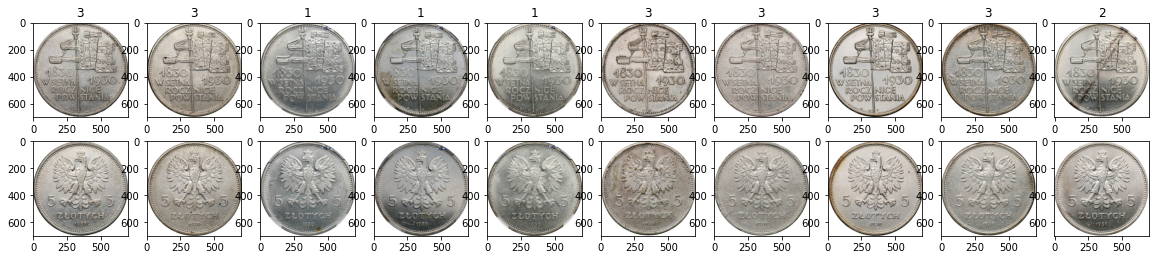

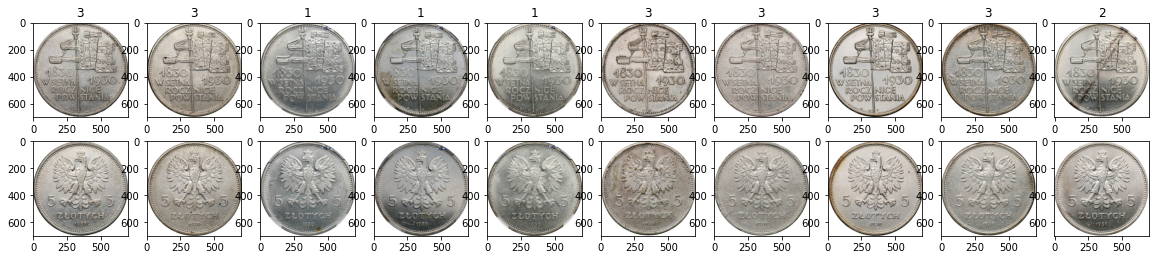

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(20,4))
ax = ax.T.flatten()
for i in range(10):
    ax[i*2].imshow(cv2.cvtColor(dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i*2+1].imshow(cv2.cvtColor(dataset.X[i][1], cv2.COLOR_BGR2RGB))
    ax[i*2].set_title(dataset.y[i])
plt.show()

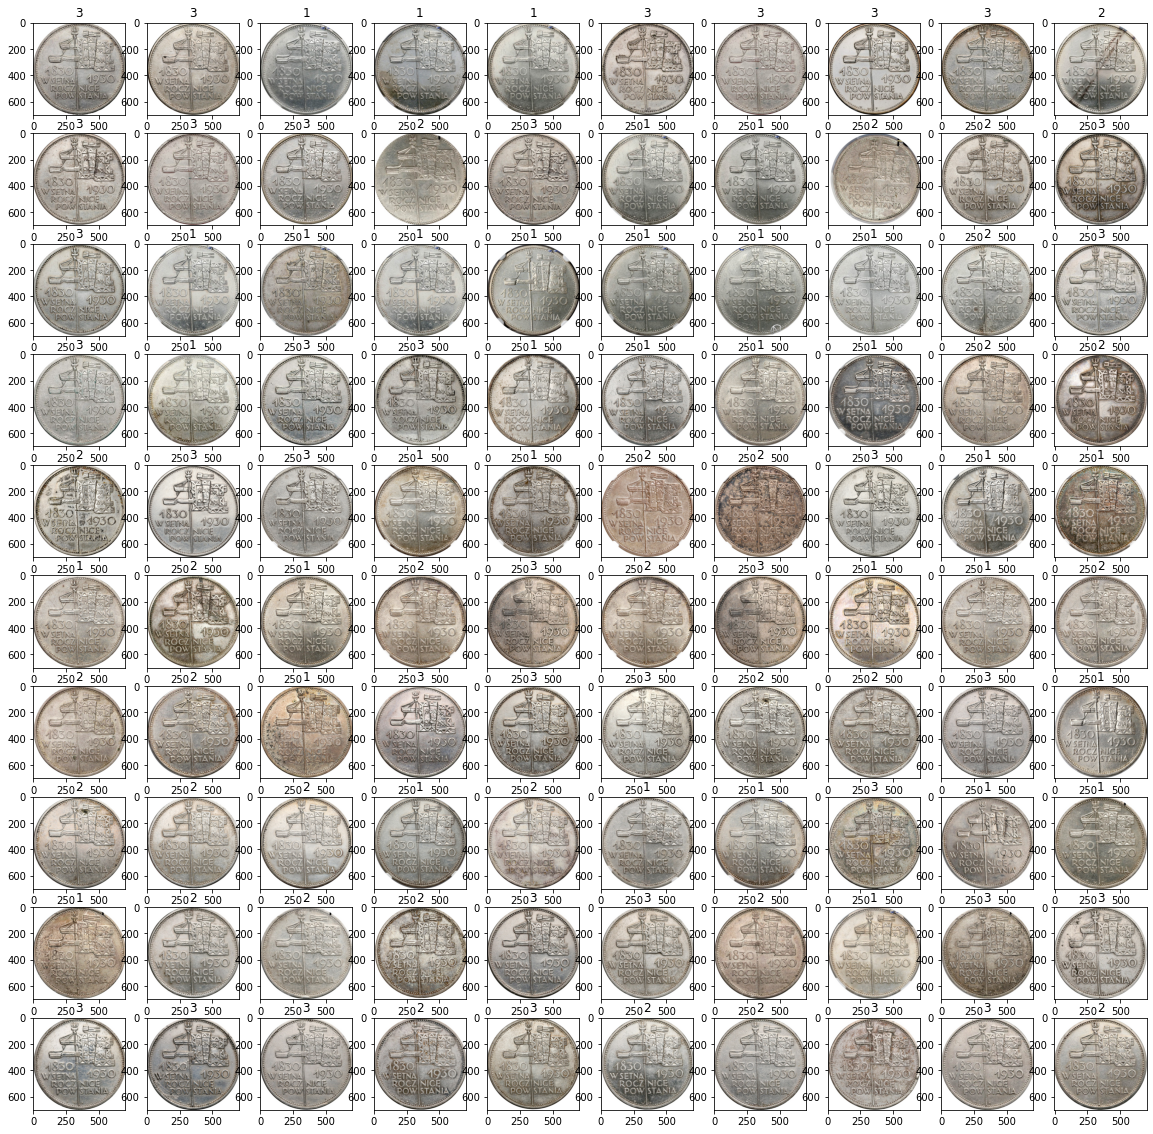

In [9]:
fig, ax = plt.subplots(10, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(100):
    ax[i].imshow(cv2.cvtColor(dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i].set_title(dataset.y[i])
plt.show()

In [ ]:
wear_marks_dataset = convert_to_wear_marks_dataset(dataset, separate_sides=separate_sides, canny_l=None)

In [ ]:
fig, ax = plt.subplots(20, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(200):
    ax[i].imshow(cv2.cvtColor(wear_marks_dataset.X[i][0], cv2.COLOR_BGR2RGB))
    ax[i].set_title(wear_marks_dataset.y[i])
plt.show()

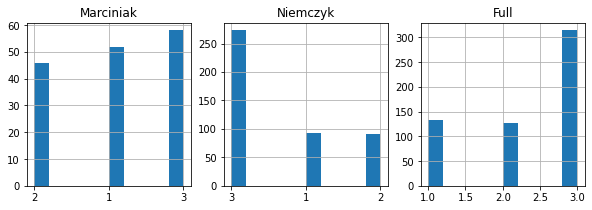

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

metadata_df = pd.read_csv(metadata_path(MARCINIAK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist(ax=ax[0])
ax[0].set_title("Marciniak")

metadata_df = pd.read_csv(metadata_path(NIEMCZYK_DATASET_PATH), sep="|")
calculate_sheldon_and_categories(metadata_df)["category"].hist(ax=ax[1])
ax[1].set_title("Niemczyk")

pd.Series(dataset.y).hist(ax=ax[2])
ax[2].set_title("Full")

plt.show()

## One side

In [13]:
%time

separate_sides = True

# dataset = join_datasets([
#   load_dataset(MARCINIAK_DATASET_PATH, separate_sides=separate_sides, ds_shape=(700,700)),
#   load_dataset(NIEMCZYK_DATASET_PATH, separate_sides=separate_sides, ds_shape=(700,700)),
# ])
# to_h5(dataset, "./one_side_ds.h5")

dataset = load_dataset(h5_path="one_side_ds.h5")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

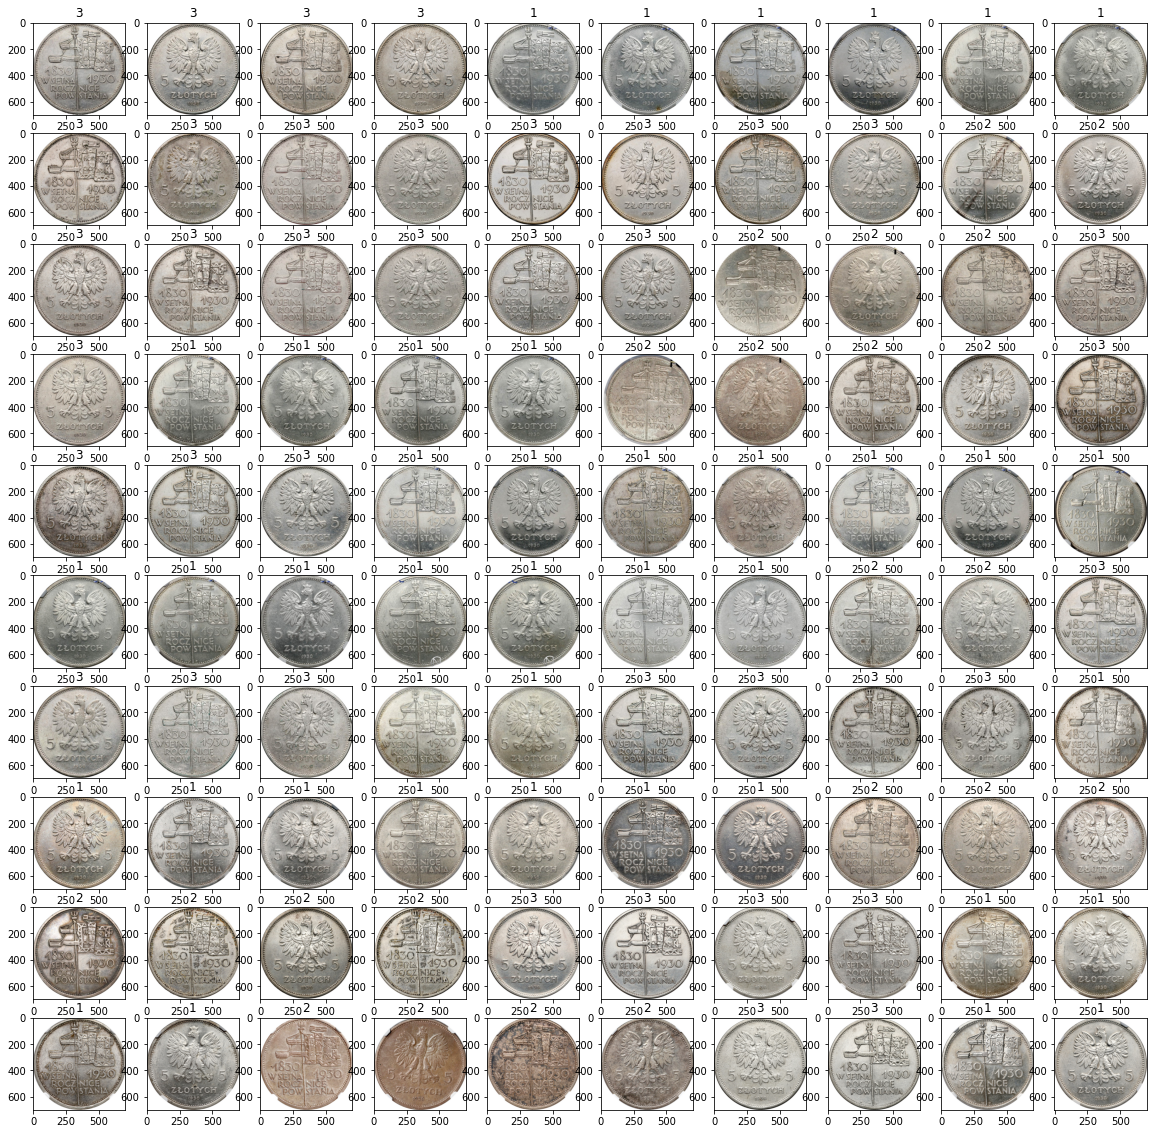

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(20,20))
ax = ax.flatten()
for i in range(100):
    ax[i].imshow(cv2.cvtColor(dataset.X[i], cv2.COLOR_BGR2RGB))
    ax[i].set_title(dataset.y[i])
plt.show()

# BoVW

In [ ]:
dataset = load_dataset(h5_path="one_side_ds.h5")
# wear_marks_dataset = convert_to_wear_marks_dataset(dataset)

In [ ]:
AVERAGE_F1_SCORE = 'weighted'

def trainModel(X_train, y_train, no_clusters, optimize_model, sift_gpu=True, precomputed_descriptor_list=False):
    global descriptor_list, im_features

    if sift_gpu:
      sift = silx_sift.SiftPlan(template=X_train[0], devicetype="GPU")
    else:
      sift = cv2.xfeatures2d.SIFT_create()

    if not precomputed_descriptor_list or 'descriptor_list' not in globals():
        descriptor_list = []
        for x in X_train:
            des = getDescriptors(sift, x, sift_gpu)
            if des is not None and len(des) > 0:
                descriptor_list.append(des)
            else:
                descriptor_list.append(np.zeros((1,128),dtype='uint8'))


    descriptors = np.vstack(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    # plotHistogram(im_features, no_clusters)
    # print("Features histogram plotted.")

    model = optimize_model(im_features, y_train)
    model.fit(im_features, y_train)

    predictions = model.predict(im_features)

    print("Train {} F1 score: ".format(AVERAGE_F1_SCORE), f1_score(y_train, predictions, average=AVERAGE_F1_SCORE))
    print("Training completed.")

    return kmeans, scale, model, im_features

def testModel(X_test, y_test, kmeans, scale, model, im_features, no_clusters, sift_gpu=True, precomputed_descriptor_list=False):
    global descriptor_list_test

    if sift_gpu:
      sift = silx_sift.SiftPlan(template=X_test[0], devicetype="GPU")
    else:
      sift = cv2.xfeatures2d.SIFT_create()

    if not precomputed_descriptor_list or 'descriptor_list_test' not in globals():
      descriptor_list_test = []
      for x in X_test:
          des = getDescriptors(sift, x, sift_gpu)
          if des is not None and len(des) > 0:
            descriptor_list_test.append(des)
          else:
            descriptor_list_test.append(np.zeros((1,128),dtype='uint8'))

    test_features = extractFeatures(kmeans, descriptor_list_test, no_clusters)
    test_features = scale.transform(test_features)
    
    predictions = model.predict(test_features)
    
    print("Test images classified.")

    plotConfusions(y_test, predictions)
    print("Confusion matrixes plotted.")
    
    print("Test {} F1 score: ".format(AVERAGE_F1_SCORE), f1_score(y_test, predictions, average=AVERAGE_F1_SCORE))
    print("Execution done.")

def execute(data, optimize_model, no_clusters, sift_gpu, precomputed_descriptor_list=False):
    [X_train, X_test, y_train, y_test] = train_test_split(data.X, data.y, test_size=0.3, random_state=42)
    kmeans, scale, model, im_features = trainModel(X_train, y_train, no_clusters, optimize_model, sift_gpu, precomputed_descriptor_list)
    testModel(X_test, y_test, kmeans, scale, model, im_features, no_clusters, sift_gpu, precomputed_descriptor_list)

In [ ]:
dataset.X = dataset.X[:100]
dataset.y = dataset.y[:100]

In [ ]:
len(descriptor_list)

70

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


/Users/telepchuk/PWr/Dan III/Magister/coin-wear-estimator/coin-wear-venv/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.
0.5 sigmoid 0.0625
Train weighted F1 score:  0.6235684997935451
Training completed.


/Users/telepchuk/PWr/Dan III/Magister/coin-wear-estimator/coin-wear-venv/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Test images classified.
Confusion matrix, without normalization
[[8 5 2]
 [1 3 1]
 [0 2 8]]
Normalized confusion matrix
[[0.53 0.33 0.13]
 [0.2  0.6  0.2 ]
 [0.   0.2  0.8 ]]


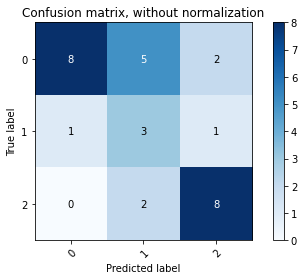

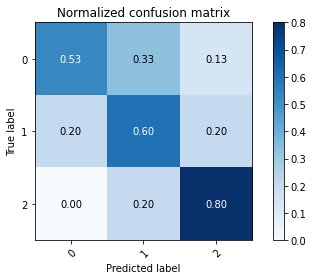

Confusion matrixes plotted.
Test weighted F1 score:  0.653968253968254
Execution done.


In [ ]:
%time
from src.bow.svc import optimize_svm

execute(dataset, optimize_svm, 16, sift_gpu=True, precomputed_descriptor_list=True)

## SIFT comparison

In [ ]:
class BriefDetector():
  def __init__(self):
    self.detector = cv2.xfeatures2d.StarDetector_create()
    self.extractor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
  
  def detectAndCompute(self, images, kp):
    kp = self.detector.detect(images, kp)
    return self.extractor.compute(images, kp)

In [ ]:
img = wear_marks_dataset.X[100]
# img = cv2.resize(img, (300,300))
sift_gpu = silx_sift.SiftPlan(template=img, devicetype="GPU")
sift = cv2.xfeatures2d.SIFT_create()
brief = BriefDetector()

kp_brief, des_brief = brief.detectAndCompute(img, None)
kp, des = sift.detectAndCompute(img, None)
kp_gpu = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in sift_gpu.keypoints(img, None)]

img_1 = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_2 = cv2.drawKeypoints(img, kp_gpu, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_3 = cv2.drawKeypoints(img, kp_brief, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(1, 3, figsize=(24,8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)
plt.show()

# CNN

In [ ]:
class CustomTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        # self.targets = torch.LongTensor(targets)
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)
        return x, int(y-1)

    def __len__(self):
        return len(self.data)

In [ ]:
data_transforms = transforms.Compose([
        # transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

[X_train, X_test, y_train, y_test] = \
  train_test_split(\
    wear_marks_dataset.X, wear_marks_dataset.y, test_size=0.3, random_state=42, stratify=wear_marks_dataset.y)

image_datasets = {
    "train": CustomTensorDataset(
            X_train,
            y_train,
            data_transforms
        ),
    "val": CustomTensorDataset(
            X_test,
            y_test,
            data_transforms
        )
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) \
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(16,5))
imshow(out)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)